Factors not captured in the analysis:
- Parkour of the race
- Abandonments and unexpected time loss
    - Riders who lost time due to crashes, injuries, illness and other reasons out of their control.
- The weather
    - Some riders do better in wet, windy or hot conditions than others.
    
Factors not used due to potential inaccuracies:
- Height
    - Value may not be accurate in all cases.
- Weight
    - The value taken for each rider is their most recent value. 
    - A rider's weight fluxuates often during a season.
    - The assumption is that every rider at the Tour will be at their ideal weight coming into it.

# Import Libraries and Set Directories

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.impute import KNNImputer

from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#import plotly.graph_objs as go
#from plotly.offline import iplot

import matplotlib as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
dPath = "D:/Data/cycling/"

# Define Functions

## Clean 2021 Data

In [3]:
def clean_2021_data(tdf_2021):
    tdf_2021.replace("AttError","Unknown",inplace=True)
    
    # Fill missing data for height and weight
    tdf_2021["Weight"] = np.where(tdf_2021["URL"]=="mark-donovan", 70, tdf_2021["Height"])
    tdf_2021["Height"] = np.where(tdf_2021["URL"]=="lucas-hamilton", 1.84, tdf_2021["Height"])
    tdf_2021["Weight"] = np.where(tdf_2021["URL"]=="lucas-hamilton", 72, tdf_2021["Weight"])
    
    # Create GC and SBW columns
    tdf_2021["GC"] = np.nan
    tdf_2021["Seconds Behind Winner"] = np.nan
    
    # Insert Team Leader Data
    tdf_2021["Team Leader"] = 0
    # UAE
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="tadej-pogacar", 1, tdf_2021["Team Leader"])
    # Lotto-NL
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="primoz-roglic", 1, tdf_2021["Team Leader"])
    # Ineos
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="geraint-thomas", 1, tdf_2021["Team Leader"])
    # Israel
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="christopher-froome", 1, tdf_2021["Team Leader"])
    # Trek
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="vincenzo-nibali", 1, tdf_2021["Team Leader"])
    # Quickstep
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="julian-alaphilippe", 1, tdf_2021["Team Leader"])
    # Movistar
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="miguel-angel-lopez", 1, tdf_2021["Team Leader"])
    # BORA
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="peter-sagan", 1, tdf_2021["Team Leader"])
    # FDJ
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="david-gaudu", 1, tdf_2021["Team Leader"])
    # Cofidis
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="guillaume-martin", 1, tdf_2021["Team Leader"])
    # Alpecin
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="mathieu-van-der-poel", 1, tdf_2021["Team Leader"])
    # EF
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="rigoberto-uran", 1, tdf_2021["Team Leader"])
    # AG2R
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="benoit-cosnefroy", 1, tdf_2021["Team Leader"])
    # Arkea
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="warren-barguil", 1, tdf_2021["Team Leader"])
    # DSM
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="soren-kragh-andersen", 1, tdf_2021["Team Leader"])
    # Lotto Soudal
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="caleb-ewan", 1, tdf_2021["Team Leader"])
    # Bahrain
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="jack-haig", 1, tdf_2021["Team Leader"])
    # BikeExchange
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="michael-matthews", 1, tdf_2021["Team Leader"])
    # Astana
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="jakob-fuglsang", 1, tdf_2021["Team Leader"])
    # Quebeka
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="sergio-luis-henao", 1, tdf_2021["Team Leader"])
    #Total Energies
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="pierre-latour", 1, tdf_2021["Team Leader"])
    # Wanty
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="louis-meintjes", 1, tdf_2021["Team Leader"])
    # B&B
    tdf_2021["Team Leader"] = np.where(tdf_2021["URL"]=="bryan-coquard", 1, tdf_2021["Team Leader"])

    return tdf_2021

## Impute Nulls

In [4]:
def ImputeNulls(df):
    df = df[df["GC"]!="DNF"]
    #all_cols = df.columns.to_list()
    #cols = [e for e in all_cols if e not in ('Rider','URL','GC','Seconds Behind Winner','Top10','Team','Nationality')]
    
    cols = ["Age","AverageResult_2UWT","AverageResult_2HC","BestResult_2UWT","BestResult_2HC","BestGTFinish",
            "numGTs","WT"]
    
    imputer = KNNImputer(n_neighbors=2)
    df[cols] = imputer.fit_transform(df[cols])
    
    return df

## Add Team Information

In [5]:
def AddTeammateData(tdf_train):
    tdf_team = pd.DataFrame()

    for team in tdf_train["Team"].unique():
        df = tdf_train[tdf_train["Team"]==team]
        
        # remove df["Team Leader"].max()

        for rider in df["Rider"].unique():
            r = df[df["Rider"]==rider]
            teammates = df[df["Rider"]!=rider]
            
            teammates = teammates[teammates["Team Leader"]!=1]

            teammates = teammates.groupby(["Team","Year"]).agg(Age_Team=("Age","mean"),
                                                               numGTs_Team=("numGTs","sum"),
                                                  BestGTFinish_Team=("BestGTFinish","max")).reset_index()
            #dom.rename(columns={"Age":"Age_Team","numGTs":"numGTs_Team","Starts":"Starts_Team"}, inplace=True)
            r = r.merge(teammates, on=['Team','Year'], how='left')

            tdf_team = tdf_team.append(r)

    return tdf_team

## Clean Train Data

In [6]:
def clean_train_data(tdf_train):
    # Remove rider with errors
    tdf_train = tdf_train[tdf_train["Rider"]!='BONNET WILLIAM']
    
    # Insert Years Since First/Last Grand Tour values
    tdf_train["YearsSinceFirstGT"] = -1
    tdf_train["YearsSinceFirstGT"] = np.where(tdf_train["FirstGT"].isna(), tdf_train["YearsSinceFirstGT"], tdf_train["Year"]-tdf_train["FirstGT"])
    tdf_train["YearsSinceLastGT"] = -1
    tdf_train["YearsSinceLastGT"] = np.where(tdf_train["LastGT"].isna(), tdf_train["YearsSinceLastGT"], tdf_train["Year"]-tdf_train["LastGT"])
    # Add value for whether rider rode Giro d'Italia that year or not
    tdf_train["Giro"] = np.where((tdf_train["YearsSinceLastGT"]==0) & (tdf_train["Year"]!=2020) , 1, 0)
    
    # Fill NA values for specific columns
    tdf_train["numTours"].fillna(0, inplace=True)
    tdf_train["numGiros"].fillna(0, inplace=True)
    tdf_train["numVueltas"].fillna(0, inplace=True)
    tdf_train["numGTs"].fillna(0, inplace=True)
    tdf_train["NumDNFs"].fillna(0, inplace=True)
    tdf_train["FirstGT"].fillna(tdf_train["Year"], inplace=True)
    tdf_train["LastGT"].fillna(tdf_train["Year"], inplace=True)
    tdf_train["FirstTour"].fillna(tdf_train["Year"], inplace=True)
    tdf_train["LastTour"].fillna(tdf_train["Year"], inplace=True)
    
    # Merge with Team Data to get value for whether rider rides for World-Tour team or not
    tdf_train = tdf_train.merge(teams, on=['Team','Year'], how='left')
    tdf_train["WT"] = np.where(tdf_train["Rank"]=="WT", 1, 0)
    del tdf_train["Rank"]
    del tdf_train["NumStageRaceDNFs"]
    del tdf_train["NumOneDayDNFs"]
    
    # Impute Nulls for specific columns
    tdf_train = ImputeNulls(tdf_train)
    
    # Add Team information
    tdf_train = AddTeammateData(tdf_train)
        
    return tdf_train

## Normalize Data

In [7]:
def NormalizeData(df):
    all_cols = df.columns.to_list()
    cols = [e for e in all_cols if e not in ('Rider','GC','Seconds Behind Winner','Top10','Team','URL','Nationality')]
    df[cols] = preprocessing.MinMaxScaler().fit_transform(df[cols])
    return df

## Variance Inflation Factor

In [8]:
def calc_vif(df, features):
    df = df[features]
    # Calculate VIF
    vif = pd.DataFrame()
    vif["Variables"] = features
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    print("Variance Inflation Factor (if higher than 5 may need reviewing):")
    display(vif)

## Model Statistics

In [9]:
# creating function to get model statistics
def get_stats(df, predictor, features):
    results = sm.OLS(df[predictor], df[features]).fit()
    print(results.summary())

## Heatmap/Correlations

In [10]:
# Correlate and plot heatmap
def heatmap(df, predictor, features):
    features_ = features.copy()
    features_.append(predictor)
    hmap = df[features_]
    sns.heatmap(hmap.corr().round(2)[[predictor]].sort_values(predictor, ascending=False), cmap="coolwarm", vmin=-1, vmax=1)
    print("Correlations:")
    display(hmap.corr().round(2)[[predictor]].sort_values(predictor, ascending=False))

## Plot Actual vs Predicted

In [11]:
# Plot the actual vs predicted values
def plot_actual_vs_pred(df, predictor):
    sns.lmplot(x = predictor + "_Actual", y = predictor + "_Pred", data=df, fit_reg=False, size=7)

In [12]:
# Plot the actual vs ranked predicted values
def plot_actual_vs_pred_ranked(df, predictor):
    sns.lmplot(x = predictor + "_Actual", y = predictor + "_Pred_Ranked", data=df, fit_reg=False, size=7)

## Linear Regression Model

In [13]:
def FitLinearRegressionModel(train, predictor, features, test_year):
    # Split train and test data
    test = train[train["Year"]==test_year]
    train = train[train["Year"]<test_year]
    
    # Alternative method to split data (Gives worse results)
    #train, test = train_test_split(train)
    
    # Remove redundant columns
    del train["Year"]
    del test["Year"]
    del train["Rider"]
    
    if predictor == "GC":
        # Remove DNF values from training data
        train = train[train[predictor]!="DNF"]
        train.dropna(subset=[predictor],inplace=True)
        train[predictor] = train[predictor].astype(str).str[:-2].astype(int)

    # Normalize Train Data
    train =  NormalizeData(train)
    # Normalize Test data
    test = NormalizeData(test)
    
    if predictor == "GC":
        # Replace DNF values with 0
        test["GC"].fillna('0.0',inplace=True)
        test["GC"].replace("DNF",'0.0',inplace=True)
        test[predictor] = test[predictor].astype(str).str[:-2].astype(int)
    
    get_stats(train, predictor, features)
    calc_vif(train, features)
    heatmap(train, predictor, features)

    # Select Model Type
    reg_model = linear_model.LinearRegression()

    # Fit model
    reg_model.fit(train[features], train[predictor])
    
    # Add column for prediction
    test[predictor + "_Pred"] = reg_model.predict(test[features]).tolist()
    # Rank in order
    test[predictor + "_Pred_Ranked"] = test[predictor + "_Pred"].rank().astype(int)
    # Round Prediction value
    test[predictor + "_Pred"] = test[predictor + "_Pred"].round(2)
    
    test.rename(columns={predictor: predictor + "_Actual"}, inplace=True)
    
    test = test[["Rider","Team",predictor + "_Pred",predictor + "_Pred_Ranked",predictor + "_Actual"]]
    
    print("Top 30 for " + predictor)
    display(test.sort_values(predictor + "_Pred_Ranked", ascending=True).head(30))
    
    
        # Calculate Residuals
    #test['Residuals'] = abs(test[predictor + "_Actual"]) - abs(test[predictor + "_Pred"])
    #test['Residuals_Ranked'] = abs(test[predictor + "_Actual"]) - abs(test[predictor + "_Pred_Ranked"])
    
    # Plot the actual vs predicted values
    plot_actual_vs_pred(test, predictor)
    plot_actual_vs_pred_ranked(test, predictor)
    
    y_true = test[predictor + "_Actual"]
    #y_pred = test[predictor + "_Pred"]
    y_pred = test[predictor + "_Pred_Ranked"]
   
    print("Explained variance regression score: " + str(metrics.explained_variance_score(y_true, y_pred)))
    print("Maximum residual error: " + str(metrics.max_error(y_true, y_pred)))   
    print("Mean absolute error regression loss: " + str(metrics.mean_absolute_error(y_true, y_pred)))    
    print("Mean squared error regression loss: " + str(metrics.mean_squared_error(y_true, y_pred)))    
    print("Mean squared logarithmic error regression loss." + str(metrics.mean_squared_log_error(y_true, y_pred)))   
    print("Median absolute error regression loss: " + str(metrics.median_absolute_error(y_true, y_pred)))   
    #print("Mean absolute percentage error regression loss: " + str(metrics.mean_absolute_percentage_error(y_true, y_pred)))   
    print("Regression score function (R^2): " + str(metrics.r2_score(y_true, y_pred)))         
    print("Mean Poisson deviance regression loss: " + str(metrics.mean_poisson_deviance(y_true, y_pred)))
    #print("Mean Gamma deviance regression loss: " + str(metrics.mean_gamma_deviance(y_true, y_pred)))       
    print("Mean Tweedie deviance regression loss: " + str(metrics.mean_tweedie_deviance(y_true, y_pred)))

    return test

## Ridge Model

In [14]:
def FitRidgeRegressionModel(train, predictor, features, test_year, alpha_value):
    # Split train and test data
    test = train[train["Year"]==test_year]
    train = train[train["Year"]<test_year]
    # Alternative
    #train, test = train_test_split(train)
    
    # Remove redundant columns
    del train["Year"]
    del test["Year"]
    del train["Rider"]
    
    if predictor == "GC":
        # Remove DNF values from training data
        train = train[train[predictor]!="DNF"]
        train.dropna(subset=[predictor],inplace=True)
        train[predictor] = train[predictor].astype(str).str[:-2].astype(int)

    # Normalize Train Data
    train =  NormalizeData(train)
    # Normalize Test data
    test = NormalizeData(test)
    
    if predictor == "GC":
        # Replace DNF values with 0
        test["GC"].fillna('0.0',inplace=True)
        test["GC"].replace("DNF",'0.0',inplace=True)
        test[predictor] = test[predictor].astype(str).str[:-2].astype(int)
    
    get_stats(train, predictor, features)
    calc_vif(train, features)
    heatmap(train, predictor, features)

    # Select Model Type
    model = Ridge(alpha=alpha_value)
    # Fit model
    model.fit(train[features], train[predictor])
    # Add column for prediction
    test[predictor + "_Pred"] = model.predict(test[features]).tolist()

    # Rank in order
    test[predictor + "_Pred_Ranked"] = test[predictor + "_Pred"].rank().astype(int)
    # Round Prediction value
    test[predictor + "_Pred"] = test[predictor + "_Pred"].round(2)
    
    test.rename(columns={predictor: predictor + "_Actual"}, inplace=True)
    
    test = test[["Rider","Team",predictor + "_Pred",predictor + "_Pred_Ranked",predictor + "_Actual"]]
    
    print("Top 30 for " + predictor)
    display(test.sort_values(predictor + "_Pred_Ranked", ascending=True).head(30))
    
    
        # Calculate Residuals
    #test['Residuals'] = abs(test[predictor + "_Actual"]) - abs(test[predictor + "_Pred"])
    #test['Residuals_Ranked'] = abs(test[predictor + "_Actual"]) - abs(test[predictor + "_Pred_Ranked"])
    
    # Plot the actual vs predicted values
    plot_actual_vs_pred(test, predictor)
    plot_actual_vs_pred_ranked(test, predictor)
    
    y_true = test[predictor + "_Actual"]
    #y_pred = test[predictor + "_Pred"]
    y_pred = test[predictor + "_Pred_Ranked"]
   
    print("Explained variance regression score: " + str(metrics.explained_variance_score(y_true, y_pred)))
    print("Maximum residual error: " + str(metrics.max_error(y_true, y_pred)))   
    print("Mean absolute error regression loss: " + str(metrics.mean_absolute_error(y_true, y_pred)))    
    print("Mean squared error regression loss: " + str(metrics.mean_squared_error(y_true, y_pred)))    
    print("Mean squared logarithmic error regression loss." + str(metrics.mean_squared_log_error(y_true, y_pred)))   
    print("Median absolute error regression loss: " + str(metrics.median_absolute_error(y_true, y_pred)))   
    #print("Mean absolute percentage error regression loss: " + str(metrics.mean_absolute_percentage_error(y_true, y_pred)))   
    print("Regression score function (R^2): " + str(metrics.r2_score(y_true, y_pred)))  
    print("Mean Poisson deviance regression loss: " + str(metrics.mean_poisson_deviance(y_true, y_pred)))
    #print("Mean Gamma deviance regression loss: " + str(metrics.mean_gamma_deviance(y_true, y_pred)))       
    print("Mean Tweedie deviance regression loss: " + str(metrics.mean_tweedie_deviance(y_true, y_pred)))

    return test

## TensorFlow (Keras)

In [ ]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
def FitRidgeRegressionModel(train, predictor, features, test_year):
    # Split train and test data
    test = train[train["Year"]==test_year]
    train = train[train["Year"]<test_year]
    # Alternative
    #train, test = train_test_split(train)
    
    # Remove redundant columns
    del train["Year"]
    del test["Year"]
    del train["Rider"]
    
    if predictor == "GC":
        # Remove DNF values from training data
        train = train[train[predictor]!="DNF"]
        train.dropna(subset=[predictor],inplace=True)
        train[predictor] = train[predictor].astype(str).str[:-2].astype(int)

    # Normalize Train Data
    train =  NormalizeData(train)
    # Normalize Test data
    test = NormalizeData(test)
    
    if predictor == "GC":
        # Replace DNF values with 0
        test["GC"].fillna('0.0',inplace=True)
        test["GC"].replace("DNF",'0.0',inplace=True)
        test[predictor] = test[predictor].astype(str).str[:-2].astype(int)
    
    get_stats(train, predictor, features)
    calc_vif(train, features)
    heatmap(train, predictor, features)

    # evaluate model with standardized dataset
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
    pipeline = Pipeline(train[features])
    kfold = KFold(n_splits=10)
    results = cross_val_score(pipeline, features, predictor, cv=kfold)
    print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
    
    return test

# Read and Clean Data

In [15]:
tdf_train = pd.read_csv(dPath+"tdf_train_2009_2020"+".csv")

In [16]:
tdf_2021 = pd.read_csv(dPath+"tdf_2021"+".csv")

In [17]:
tdf_2021 = clean_2021_data(tdf_2021)

In [18]:
tdf_train = pd.concat([tdf_train, tdf_2021], ignore_index=True)

In [19]:
teams = pd.read_csv(dPath+"Teams.csv", engine="python")

In [20]:
#tdf_train.isna().sum()

In [21]:
tdf_train = clean_train_data(tdf_train)

# Select Model Variables

In [22]:
# Print all possible feature variables
all_cols = tdf_train.columns.to_list()
all_cols = [e for e in all_cols if e not in ('Rider','Year','GC','Seconds Behind Winner','Top10','Team','URL','Nationality')]
print(all_cols)

['Age', 'Team Leader', 'AverageResult_2UWT', 'AverageResult_2HC', 'BestResult_2UWT', 'BestResult_2HC', 'Total_KMs', 'UCIPoints', 'NumStageRaces', 'NumOneDayRaces', 'Height', 'Weight', 'numTours', 'numGiros', 'numVueltas', 'BestGTFinish', 'BestTourFinish', 'BestGTStageFinish', 'FirstGT', 'LastGT', 'FirstTour', 'LastTour', 'NumDNFs', 'numGTs', 'YearsSinceFirstGT', 'YearsSinceLastGT', 'Giro', 'WT', 'Age_Team', 'numGTs_Team', 'BestGTFinish_Team']


In [110]:
features2 = ['Age', 'Team Leader', 'BestResult_2UWT',
              'Total_KMs', 'UCIPoints', 'BestGTFinish', 'NumStageRaces',
              'NumDNFs', 'numGTs', 'YearsSinceLastGT', 'Giro', 'BestGTFinish_Team']

In [111]:
features3 = ['Age', 'Team Leader', 'AverageResult_2UWT','BestResult_2UWT',
              'Total_KMs', 'UCIPoints', 'NumStageRaces', 'NumOneDayRaces', 'BestGTFinish',  
              'NumDNFs', 'numGTs', 'WT', 'YearsSinceFirstGT', 
              'YearsSinceLastGT', 'Giro', 'numGTs_Team', 'BestGTFinish_Team']

# Run Models

                                 OLS Regression Results                                
Dep. Variable:                     GC   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                              1128.
Date:                Sat, 26 Jun 2021   Prob (F-statistic):                        0.00
Time:                        00:36:31   Log-Likelihood:                         -7850.9
No. Observations:                1622   AIC:                                  1.573e+04
Df Residuals:                    1610   BIC:                                  1.579e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

,Variables,VIF
0,Age,13.931388
1,Team Leader,1.255720
2,BestResult_2UWT,1.515384
3,Total_KMs,20.700913
4,UCIPoints,1.340991
5,BestGTFinish,4.265004
6,NumStageRaces,12.669711
7,NumDNFs,2.618040
8,numGTs,10.660968
9,YearsSinceLastGT,7.924198


Correlations:


,GC
GC,1.00
BestGTFinish,0.70
Total_KMs,0.28
BestResult_2UWT,0.24
BestGTFinish_Team,0.09
Giro,0.04
NumDNFs,0.03
YearsSinceLastGT,-0.01
Age,-0.02
NumStageRaces,-0.06


Top 30 for GC


,Rider,Team,GC_Pred,GC_Pred_Ranked,GC_Actual
1,YATES ADAM,Mitchelton-Scott,-11.08,1,28
0,BERNAL EGAN,Team INEOS,1.38,2,1
5,QUINTANA NAIRO,Movistar Team,3.19,3,8
0,ALAPHILIPPE JULIAN,Deceuninck - Quick Step,4.68,4,5
1,BUCHMANN EMANUEL,BORA - hansgrohe,9.53,5,4
6,BARDET ROMAIN,AG2R La Mondiale,13.20,6,15
0,MAS ENRIC,Deceuninck - Quick Step,15.62,7,22
0,THOMAS GERAINT,Team INEOS,16.48,8,2
0,KRUIJSWIJK STEVEN,Team Jumbo-Visma,20.35,9,3
0,URÁN RIGOBERTO,EF Education First,21.08,10,7


Explained variance regression score: 0.6657064894472351
Maximum residual error: 109
Mean absolute error regression loss: 19.07792207792208
Mean squared error regression loss: 658.2207792207793
Mean squared logarithmic error regression loss.0.2799728231754685
Median absolute error regression loss: 16.0
Regression score function (R^2): 0.6654080429529751
Mean Poisson deviance regression loss: 11.402891827711008
Mean Tweedie deviance regression loss: 658.2207792207793


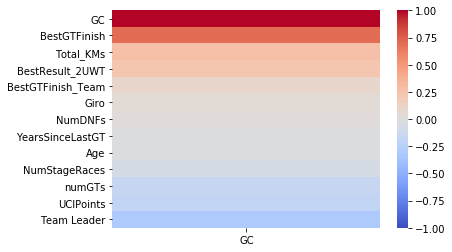

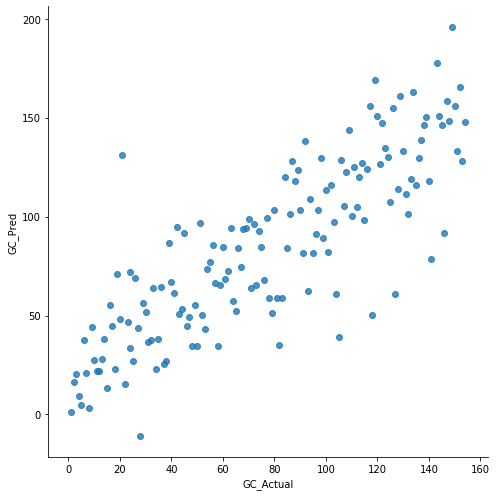

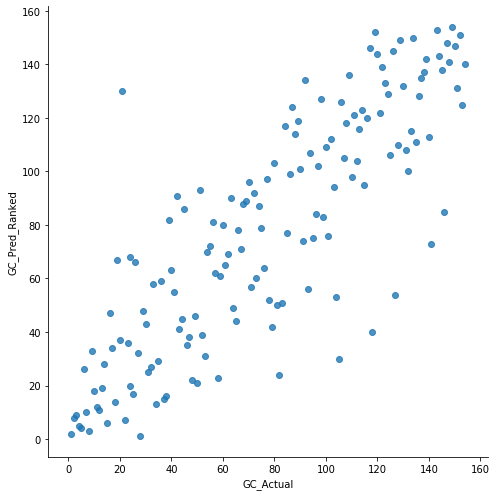

In [118]:
ridgemodel = FitRidgeRegressionModel(tdf_train, "GC", features2, 2019, 1)

In [119]:
ridgemodel.to_csv(dPath+"tdf_2019_prediction.csv", index=False)

                                 OLS Regression Results                                
Dep. Variable:                     GC   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                              2301.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):                        0.00
Time:                        23:42:31   Log-Likelihood:                         -9280.2
No. Observations:                1922   AIC:                                  1.857e+04
Df Residuals:                    1915   BIC:                                  1.861e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

,Variables,VIF
0,Age,4.747038
1,Team Leader,1.252000
2,AverageResult_2UWT,1.761505
3,UCIPoints,1.390934
4,Total_KMs,10.834998
5,BestGTFinish,3.376293
6,BestGTFinish_Team,9.305787


Correlations:


,GC
GC,1.00
BestGTFinish,0.71
Total_KMs,0.26
AverageResult_2UWT,0.25
BestGTFinish_Team,0.11
Age,-0.01
UCIPoints,-0.22
Team Leader,-0.31


Top 30 for GC


,Rider,Team,GC_Pred,GC_Pred_Ranked,GC_Actual
1,POGAČAR TADEJ,UAE-Team Emirates,-31.43,1,0
1,VAN AERT WOUT,Team Jumbo-Visma,-5.03,2,0
1,ROGLIČ PRIMOŽ,Team Jumbo-Visma,0.35,3,0
2,GAUDU DAVID,Groupama - FDJ,2.19,4,0
0,LÓPEZ MIGUEL ÁNGEL,Movistar Team,7.41,5,0
2,ALAPHILIPPE JULIAN,Deceuninck - Quick Step,11.09,6,0
0,THOMAS GERAINT,INEOS Grenadiers,20.60,7,0
0,URÁN RIGOBERTO,EF Education - Nippo,23.46,8,0
1,CARAPAZ RICHARD,INEOS Grenadiers,24.04,9,0
1,MARTIN GUILLAUME,"Cofidis, Solutions Crédits",26.40,10,0


Explained variance regression score: 0.0
Maximum residual error: 184
Mean absolute error regression loss: 92.5
Mean squared error regression loss: 11377.5
Mean squared logarithmic error regression loss.18.976815286601788
Median absolute error regression loss: 92.5
Regression score function (R^2): 0.0
Mean Poisson deviance regression loss: 185.0
Mean Tweedie deviance regression loss: 11377.5


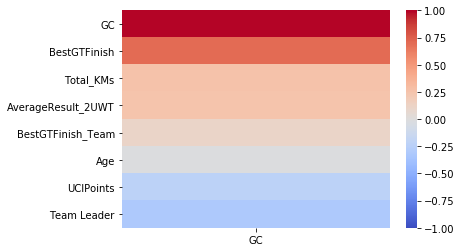

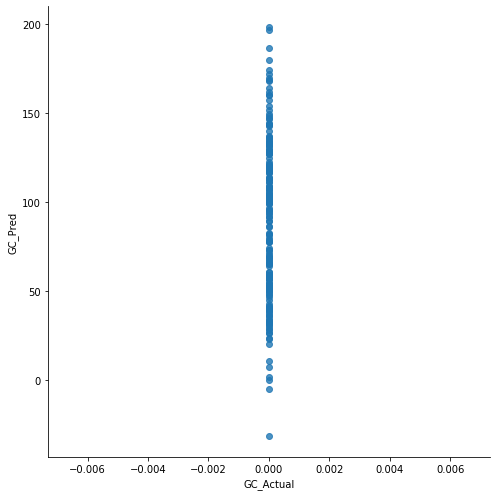

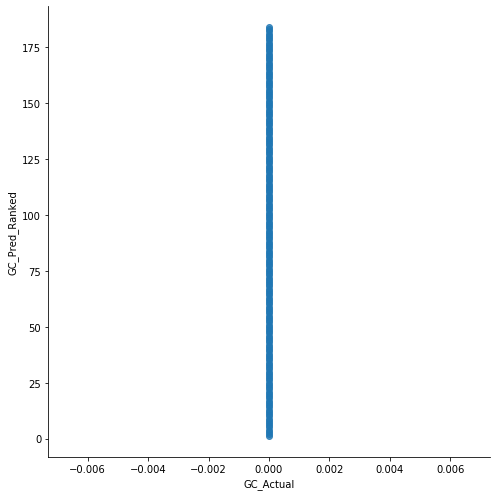

In [26]:
linearmodel = FitLinearRegressionModel(tdf_train, "GC", features1, 2021)

In [28]:
1/0

ZeroDivisionError: division by zero

In [ ]:
def scatter_plot_1(df, dim1, dim2):
    # creating trace1
    trace1 = go.Scatter(
                        x = df[dim1],
                        y = df[dim2],
                        mode = "markers",
                        name = "2014",
                        marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                        text= tdf_train_fin["Rider"])

    data = [trace1]
    layout = dict(title = dim1 + 'vs' + dim2,
                  xaxis= dict(title= dim1,ticklen= 5,zeroline= False),
                  yaxis= dict(title= dim2,ticklen= 5,zeroline= False)
                 )
    fig = dict(data = data, layout = layout)
    iplot(fig)